In [176]:
import pandas as pd
import openai
from dotenv import load_dotenv
import os
import re

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")
pd.set_option('display.max_colwidth', None)

def extract_answer_tag(text: str) -> str:
    answer_match = re.search(r'<answer>(.*?)</answer>', text, re.DOTALL)
    answer_content = answer_match.group(1) if answer_match else None
    return answer_content

In [177]:
SQL_EVALUATION_PROMPT = """
You are a SQL expert. You are given a SQL query and a expected answer.
You need to evaluate if the SQL query is correct and if it answers the question.
You need to return a boolean value.
"""

SQL_CORRECTNESS_PROMPT = """
You are a SQL expert. You are given 2 results from a SQL query. One corresponds to the
gold query results, which are meant to be the truth. The other corresponds to another
query results.
You need to evaluate if the results from this other query is correct, meaning, if they
output the same results in terms of content. Even if they differ by commas, parenthesis
or other characters, you need to evaluate the actual content.
You need to return a boolean value.
"""


def call_gpt_api_to_check_query(sql_query, expected_answer, model="gpt-3.5-turbo"):
    prompt = """
    SQL query: {sql_query}
    Expected answer: {expected_answer}

    Return only the boolean value. In enclosed tags like <answer>true</answer> or <answer>false</answer>.
    """
    prompt = prompt.format(sql_query=sql_query, expected_answer=expected_answer)
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": SQL_EVALUATION_PROMPT},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

def call_gpt_api_to_check_query_answer(sql_query_results, expected_query_answer, model="gpt-3.5-turbo"):
    prompt = """
    SQL query results: {sql_query}
    Gold query answer: {expected_answer}

    Return only the boolean value. In enclosed tags like <answer>true</answer> or <answer>false</answer>.
    """
    prompt = prompt.format(sql_query=sql_query_results, expected_answer=expected_query_answer)
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": SQL_CORRECTNESS_PROMPT},
            {"role": "user", "content": prompt}
        ]
    )
    return response.choices[0].message.content

In [178]:
test_type = 'spider-style'

In [179]:
df = pd.read_csv(f'{test_type}/test_file_results_1_agent_only.csv')

# df.head()

In [182]:
df['llm_query'] = df['llm_query'].str.replace('\n', ' ')
# df['llm_query'] = df['llm_query'].str.lower()
df['gold_sql'] = df['gold_sql'].str.replace('\n', ' ')
# df['expected_query'] = df['expected_query'].str.lower()

In [183]:
# df = pd.read_csv('exercise-3/test_file_results_auditor.csv', dtype={'auditor_answer': str, 'auditor_query_results_answer': str})
# df.head()

In [184]:
# df.head(20)

In [185]:
auditor_answers = []
for i, item in df.iterrows():
    sql_query = item['llm_query']
    expected_answer = item['gold_sql']
    result = call_gpt_api_to_check_query(sql_query, expected_answer)
    auditor_answers.append(result)

df['auditor_answer'] = auditor_answers
df.auditor_answer = df.auditor_answer.apply(lambda x: extract_answer_tag(x))
df.to_csv(f'{test_type}/test_file_results_auditor_1_agent_only.csv', index=False)

In [186]:
# df.head()

In [187]:
df.auditor_answer.value_counts()

auditor_answer
true     18
false     9
Name: count, dtype: int64

In [188]:
df.auditor_answer.value_counts(normalize=True) * 100

auditor_answer
true     66.666667
false    33.333333
Name: proportion, dtype: float64

In [189]:
# df.iloc[10]

In [190]:
# call_gpt_api_to_check_query_answer(df.iloc[10].llm_query_raw_results, df.iloc[10].expected_query_raw_results)

In [191]:
# df.iloc[15]

In [192]:
# call_gpt_api_to_check_query_answer(df.iloc[15].llm_query_raw_results, df.iloc[15].expected_query_raw_results)

In [193]:
auditor_query_answers = []
for i, item in df.iterrows():
    sql_query = item['llm_executed_query_results']
    expected_answer = item['gold_sql_results']
    result = call_gpt_api_to_check_query_answer(sql_query, expected_answer)
    auditor_query_answers.append(result)

df['auditor_query_results_answer'] = auditor_query_answers
df.auditor_query_results_answer = df.auditor_query_results_answer.apply(lambda x: extract_answer_tag(x))
df.to_csv(f'{test_type}/test_file_results_auditor_1_agent_only.csv', index=False)

In [194]:
# df.head()

In [195]:
df.auditor_query_results_answer.value_counts()

auditor_query_results_answer
true     19
false     8
Name: count, dtype: int64

In [196]:
df.auditor_query_results_answer.value_counts(normalize=True) * 100

auditor_query_results_answer
true     70.37037
false    29.62963
Name: proportion, dtype: float64

In [149]:
# df.head()

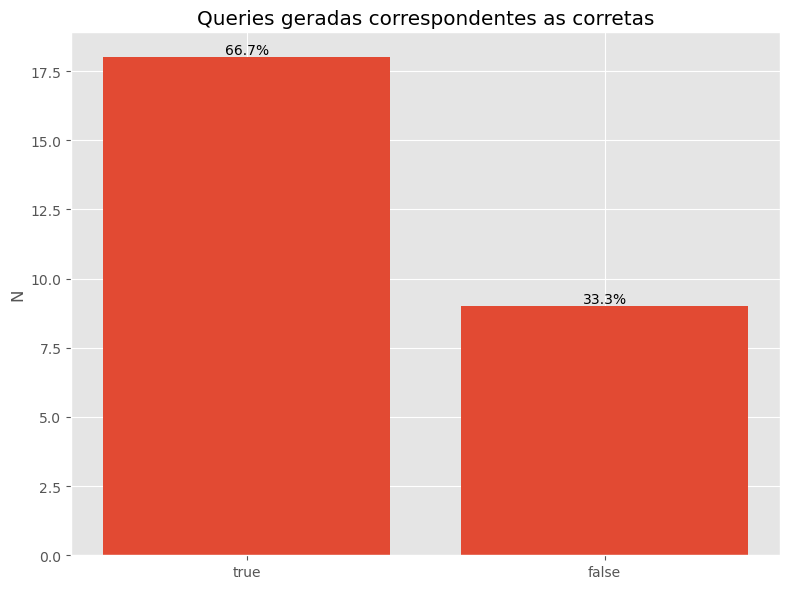

In [197]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

value_counts = df.auditor_answer.value_counts()
percentages = df.auditor_answer.value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts.values)

for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentage:.1f}%',
             ha='center', va='bottom')


plt.title('Queries geradas correspondentes as corretas')
# plt.xlabel('Corret')
plt.ylabel('N')
plt.tight_layout()

plt.show()

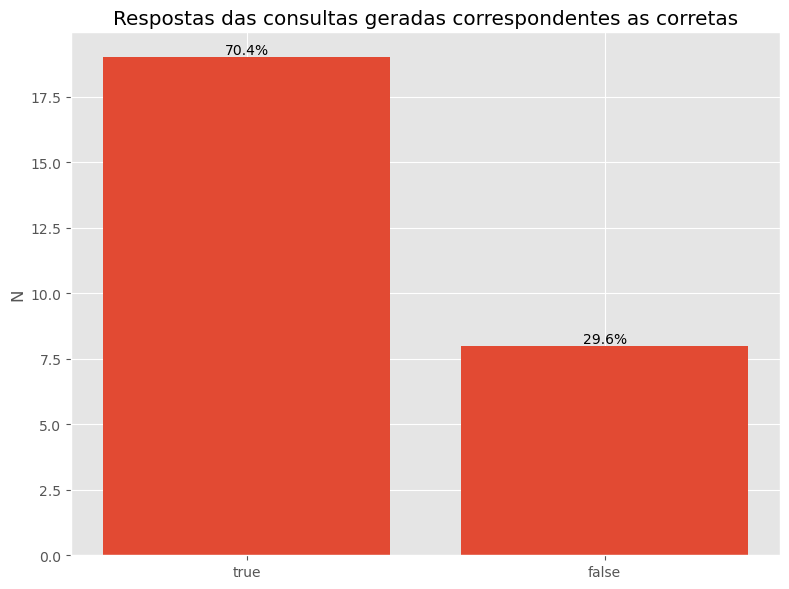

In [198]:
value_counts = df.auditor_query_results_answer.value_counts()
percentages = df.auditor_query_results_answer.value_counts(normalize=True) * 100


plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts.values)

for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{percentage:.1f}%',
             ha='center', va='bottom')


plt.title('Respostas das consultas geradas correspondentes as corretas')
# plt.xlabel('Corret')
plt.ylabel('N')
plt.tight_layout()

plt.show()

In [152]:
1

1